# Project 1: Food Vision Big

## Check GPU for Mixed Precision Training Capability

> The author of this notebook is utilizing Amazon Sagemaker, specifically a P3 instance with a V100 GPU. For Mixed Precision Training to work, the GPU you're running must have a 'Compute Capability' of 7.0 or higher. That information can be found here for NVIDIA: https://developer.nvidia.com/cuda-gpus#compute

In [1]:
# Check which GPU you're using
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-816103ee-04c7-29f1-b755-75af5ee4363a)


## Get helper functions

This `helper_functions.py` is from other works. We can download it from here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Download helper_functions.py if it does not exist
import os
if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' exists, skipping download.")

[INFO] 'helper_functions.py' exists, skipping download.


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

2023-01-19 16:15:07.066120: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Use TensorFlow Datasets to Download Data

[Guide and datasets list here.](https://www.tensorflow.org/datasets)

In [4]:
# Get packages
%pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.5/146.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 1.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 46.9 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=fe1b8affee6ee8260e670515d539c58ed01ec5bfecc9dbb7164f8adbae37aebb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/76/40/54/417a4d64a01b61b247658d83597e1dc83c3de01fc0cef44972
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# turn off check for Google authentication for the public bucket these datasets reside in
tfds.core.utils.gcs_utils._is_gcs_disabled = True
os.environ['NO_GCE_CHECK'] = 'true'

# List all available datasets
datasets_list = tfds.list_builders() # get all available in TFDS

# Check if food101 is in the list
# print("food101" in datasets_list)

In [7]:
# # Load in the Food101 data (this can take a few minutes, 5GB)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"], # each data set is potentially different, some have train, valid, test
                                            shuffle_files=True,
                                            as_supervised=True, # data gets returns in tuple format (data, label)
                                            with_info=True) # this provides the data back to the ds_info variable

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /home/ec2-user/tensorflow_datasets/food101/2.0.0.incomplete1714QE/food101-train.tfrecord*...:   0%| …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/ec2-user/tensorflow_datasets/food101/2.0.0.incomplete1714QE/food101-validation.tfrecord*...:  …

Dataset food101 downloaded and prepared to /home/ec2-user/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring Food101 data from TFDS

We need to find:
* Class names
* Shape of image tensors
* Datatype of the data
* What do labels look like (one-hot vs label encoded)
* Do the labels match up with the class_names?

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about the training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 21
    Class name (str form): chocolate_cake
    


In [13]:
# What does our image tensor from TFDS Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 32,  14,   0],
        [ 31,  13,   0],
        [ 28,  12,   0],
        ...,
        [ 54,  34,  10],
        [ 53,  33,   9],
        [ 51,  31,   7]],

       [[ 28,  10,   0],
        [ 28,  10,   0],
        [ 27,  11,   0],
        ...,
        [ 56,  36,  12],
        [ 55,  35,  11],
        [ 54,  34,   9]],

       [[ 30,  12,   0],
        [ 31,  13,   0],
        [ 31,  15,   0],
        ...,
        [ 58,  38,  13],
        [ 58,  38,  13],
        [ 58,  38,  11]],

       ...,

       [[135,  80,   0],
        [136,  81,   1],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[137,  82,   2],
        [137,  82,   2],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[136,  81,   1],
        [135,  80,   0],
        [135,  80,   0],
        ...,
        [ 14,   7,   

In [14]:
# What are the min and max values of our image tensor? RGB 0-255, need to normalize
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

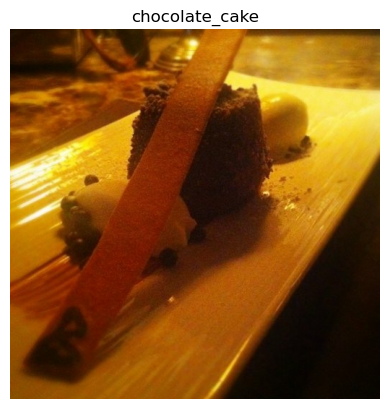

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image to verify label is matched to training data correctly
plt.axis(False)

## Create preprocessing functions for our data

Neural Networks perform best when data is prepared in a certain way (e.g., batched, normalized, etc.)

What we know about our data:
* In `uint8` datatype
* Comprised of various sized tensors
* Not scaled (pixels are RGB values)

What models like:
* Data in `float32` or mixed precision `float16` and `float32`
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size (typically 32)
* Scaled (values between 0 & 1), also called normalization

EfficientNetBX pretrained model will be used from `tf.keras.applications.efficientnet`, these models have a layer for rescaling built in.

This means our functions need to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [16]:
# Make function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype form 'uint8' -> 'float32' and reshapes
    image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    # image = image / 255. # scales image values, however, this is not required for EfficientNetBX models from tf.keras.applications.efficientnet as a normalization/scaling layer exists
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [17]:
# preprocess a single sample image and check outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[32 14  0]
  [31 13  0]
  [28 12  0]
  ...
  [54 34 10]
  [53 33  9]
  [51 31  7]]

 [[28 10  0]
  [28 10  0]
  [27 11  0]
  ...
  [56 36 12]
  [55 35 11]
  [54 34  9]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[29.19898    11.198979    0.        ]
  [28.285715   12.285714    0.        ]
  [30.852041   15.494898    0.28061217]
  ...
  [52.9336     32.505074    8.7193365 ]
  [54.025528   34.025528   10.025528  ]
  [53.800972   33.800972    9.571359  ]]

 [[33.09694    15.096939    1.193878  ]
  [33.785713   17.785715    2.785715  ]
  [31.785713   16.428572    1.2142859 ]
  ...
  [63.60206    42.530632   15.346998  ]
  [61.647934   40.7857     13.928558  ]
  [60.785713   41.714287   12.020403  ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & Prepare datasets

Create a performant data input pipeline.

As a resource, the [tf.data API](https://www.tensorflow.org/guide/data) as well as [TesorFlow pipeline optimizations](https://www.tensorflow.org/guide/data_performance).

In [18]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefect it (load it faster). buffer_size limits shuffling to limit RAM overload
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> The above cells maps this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements, then we'll batch a collection of 32. Finally we'll prepare batches via 'prefetch' while the model is training on the previous batch.

## Create modeling callback

Callbacks to create:
* Tensorboard callback to log training results for visualization
* ModelCheckpoint callback to save our model's progress after feature extraction

In [36]:
# Create TensorBoard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=2) # don't print to stdout

## Setup mixed precision training

[Mixed Precision Documentation](https://www.tensorflow.org/guide/mixed_precision)

Mixed precision utilized a mix of float16 and float32 to improve RAM usage and speed up processes.

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
# mixed precision is broken for EfficientNetB0 in TensorFlow, disabling
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


## Build feature extraction model

In [68]:
from tensorflow.keras import layers
# preprocessing not needed for EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing

# API was expecting input data in theanos format, this changes it to TensorFlow format
from keras import backend as K
K.set_image_data_format('channels_last')

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False) # tf.keras.applications.EfficientNetB0 is the old API call, if you use this with 2.10 it will fail. Updated to efficientnet.EfficientNetB0 and all is well
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have scaling layer built in, otherwise use below
# x = preprocessing.Rescaling(1./255) # 255 represents 0-255 for RGB values on pictures
x = base_model(inputs, training=False) # makes sure layers are in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x) # not using activation function here, we'll separate so we can convert to float32
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



## Setup Mixed Precision Training 

> To get mixed precision to work the new API must be used, tf.keras.applications.efficientnet.EfficientNetB0 as opposed to tf.keras.applications.EfficientNetB0

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policies (checking if we're using mixed precision)

In [30]:
# Check the dtype_policy attributes of the layers in the model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

# This is all float32 as mixed precision isn't currently functional for EfficientNetB0 in current TensorFlow version 2.9.2

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [31]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # checks efficientnetB0 layers
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

# again this is only for reference, mixed precision isn't currently working

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fit the feature extraction model

Our goal is to fine-tune a pretrained model, we'll follow the order of:
1. Build a feature extraction model (train a couple of output layers with base layers frozen)
2. Fine-tune some of the base model layers

I'm using 3 epochs to train the top two layers as all layers of EfficientNetB0 are currently frozen.
To save time for this experiment I also reduce the validation data to 15%.

In [37]:
# Fit feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230119-165811


Epoch 1/3
2366/2368 [============================>.] - ETA: 0s - loss: 0.7860 - accuracy: 0.7917
Epoch 1: val_accuracy improved from -inf to 0.73241, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 61s 25ms/step - loss: 0.7860 - accuracy: 0.7917 - val_loss: 0.9764 - val_accuracy: 0.7324
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.7460 - accuracy: 0.8029
Epoch 2: val_accuracy did not improve from 0.73241
2368/2368 [==============================] - 61s 25ms/step - loss: 0.7460 - accuracy: 0.8029 - val_loss: 0.9757 - val_accuracy: 0.7311
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.8114
Epoch 3: val_accuracy improved from 0.73241 to 0.73556, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 61s 25ms/step - loss: 0.7128 - accuracy: 0.8114 - val_loss: 0.9810 - val_accuracy: 0.7356


In [38]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 15s 19ms/step - loss: 0.9937 - accuracy: 0.7314


### Load anc evaluate checkpoint weights

To validate the checkpoint is working I'll clone the model and load the weights.
1. Clone model via `tf.keras.models.clone_model()` to make a copy of the feature extraction model with weights reset
2. Use the `load_weights()` method to modify the default random weights to match the checkpoint weights
3. Use the `evaluate()` method to confirm the same metric results

Checkpoints provide me with the ability to revert the model back to the optimal values should subsequent experiments result in subpar values

In [39]:
# Clone the model
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [40]:
# Load checkpoint weights into cloned_model
cloned_model.load_weights(checkpoint_path)

> When you make a change to the model, including loading in weights from a checkpoint, we have to recompile the model

In [42]:
# compile the cloned_model with the weights of the original model
cloned_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [43]:
# Evaluate the model to confirm the results are the same
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 20s 21ms/step - loss: 1.4080 - accuracy: 0.6338


### Save the model

Using the `save()` method I can save the entire model.

Conflicts with `EfficientNetB0` in TensorFlow 2.10 are problematic. Did not try converting to TF 2.9.1, would likely fix the error of being able to use Keras API to save models.

In [94]:
# Define model save directory
# model_save_dir = "saved_models"

# save the model
# tf.keras.models.save_model(model, model_save_dir)

I will evaluate that the model saved correctly

In [95]:
# load model
# loaded_saved_model = tf.keras.models.load_model(model_save_dir)

In [96]:
# evaluate the loaded_saved_model
# keras_loaded_saved_model.summary()

### The save and load api's are broken when used in conjunction with EfficientNet.

## Prepare model layers for fine-tuning

Given that I have 10,000 images, fine-tuning frozen layers of the base model will likely provide greater results

> The goal of this notebook is to show improvement over the [DeepFood Paper](https://arxiv.org/pdf/1606.05675.pdf), 77.4% top-1 accuracy

In [70]:
# check model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [71]:
# Check curracy accuracy on test data
model.evaluate(test_data)

790/790 [==============================] - 18s 19ms/step - loss: 4.7034 - accuracy: 0.0095


[4.703382968902588, 0.0095445541664958]

In [72]:
# view layers within the model
for layer in model.layers:
    layer.trainable = True # sets all layers to be trainable
    print(layer.name, layer.dtype, layer.dtype_policy) # also checks for mixed precision

input_layer float32 <Policy "float32">
efficientnetb0 float32 <Policy "mixed_float16">
global_average_pooling2d_3 float32 <Policy "mixed_float16">
dense_1 float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">


> We can see that index 1, the second layer of this model, is the `base_model` EfficientNetB0 retrieved from `tf.keras.applications.efficientnet.EfficientNetB0`

To check the layers of EfficientNetB0, I can access the `layers` of `model.layers[1]`

In [74]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_6 True float32 <Policy "float32">
rescaling_12 True float32 <Policy "mixed_float16">
normalization_5 True float32 <Policy "mixed_float16">
rescaling_13 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed

> I can see that the layers that need to be using mixed precision are the right type and that all layers of the model are currently trainable. Since I have 75000+ images I will leave all layers trainable, otherwise with less data I would modify to only include a portion of the top layers

Because training can take a long while, it will be ideal to stop training when improvements cease. As such, I will include an `EarlyStopping` callback function that tracks `val_loss`

I will also create the `ReduceLROnPlateaue` callback. This callback will reduce the learning rate by a factor of 5 whent he validation loss is not improving.

In [75]:
# stop training if val_loss doesn't improve in 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save the best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [76]:
# Create learning rate plateaue callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply learning rate by 0.2
                                                 patience=2,
                                                 verbose=1, # prints out when this callback is used
                                                 min_lr=1e-7)

> Since I am fine-tuning the model I will set the learning rate to a 10 fold reduction over the standard `Adam()` learning rate, from 1e-3 to 1e-4.

In [77]:
# compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              metrics=["accuracy"])

### Fit the model

Setting the model to run for 100 epochs with the `EarlyStopping` callback in place. Also implemented mixed-precision to reduce the time it takes per epoch.

In [90]:
# %conda list

In [93]:
# conflicts with EfficientNetB0 and tensorflow 2.10. Downgrading to 2.9.1 to solve
# %conda install tensorflow=2.9.1

In [92]:
# Fine-tune all layers
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # max of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # 15% validation data per epoch
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping,# stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230119-192801


Epoch 1/100
2368/2368 [==============================] - 172s 72ms/step - loss: 0.1846 - accuracy: 0.9432 - val_loss: 0.8759 - val_accuracy: 0.7963 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 173s 72ms/step - loss: 0.1294 - accuracy: 0.9596 - val_loss: 0.9727 - val_accuracy: 0.7850 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9669
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 173s 73ms/step - loss: 0.1010 - accuracy: 0.9669 - val_loss: 1.1076 - val_accuracy: 0.7789 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 172s 72ms/step - loss: 0.0190 - accuracy: 0.9948 - val_loss: 1.0940 - val_accuracy: 0.8091 - lr: 2.0000e-05


In [100]:
# save model directory
# save_model_dir = "saved_models/"

# save the model after fine-tuning
# tf.keras.models.save_model(model, save_model_dir)

> Still broken even when using 2.9.1

In [102]:
# evaluate model
model.evaluate(test_data)

790/790 [==============================] - 16s 19ms/step - loss: 1.0977 - accuracy: 0.8123


[1.0977178812026978, 0.8122772574424744]

> 81.22% evaluation accuracy result. This is ~4% higher than the DeepFood paper results

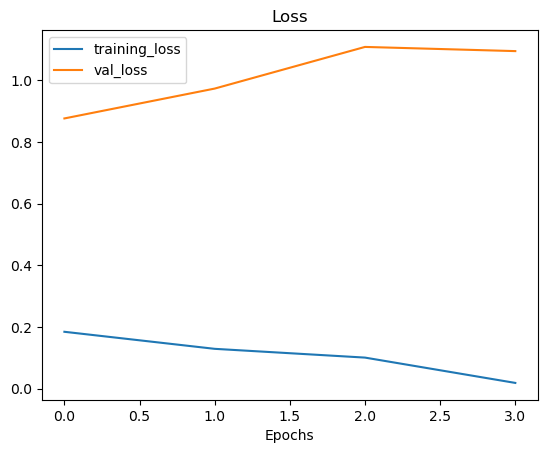

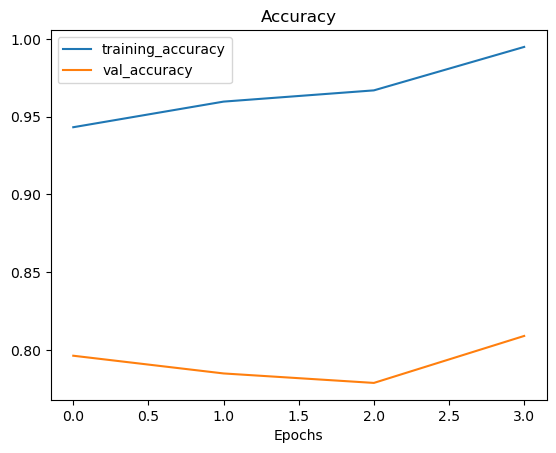

In [103]:
# plot loss curves
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

> It would take a long time to see convergence on these models. Modifying the patience value for the `EarlyStopping` callback would likely provide more insights and better performance in the long run.